# Final Project HAM10000 - balanced - vgg16

In [4]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00


In [5]:
import wandb

In [6]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd
import os
import shutil

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
import torchvision
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, random_split

In [11]:
import seaborn as sns
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from scipy import stats
from sklearn.utils import resample

# Defining the data

In [12]:
# Define directories
data_dir = "/content/drive/MyDrive/Data Scientist/final project/HAM10000/dataverse_files/HAM10000_images_part_1"

In [13]:
# Load the dataset
skin_df = pd.read_csv("/content/drive/MyDrive/Data Scientist/final project/HAM10000/dataverse_files/HAM10000_metadata")
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset  
0  vidir_modern  
1  vidir_modern  
2  vidir_modern  
3  vidir_modern  
4  vidir_modern

In [14]:

# Print the count of images per diagnosis
print(skin_df['dx'].value_counts())

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [15]:
# Extract unique labels into a list
labels = skin_df['dx'].unique().tolist()
print(labels)

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


In [16]:
image_path = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(data_dir, '**', '*.jpg'), recursive=True)
}

In [17]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [18]:
# Create new columns
skin_df['image_path'] = skin_df['image_id'].map(image_path.get) # Map image paths to image_ids
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) # create cell type column from dx with full class names
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes # Convert cell type to categorical

In [19]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset                                         image_path  \
0  vidir_modern  /content/drive/MyDrive/Data Scientist/final pr...   
1  vidir_modern  /content/drive/MyDrive/Data Scientist/final pr...   
2  vidir_modern  /content/drive/MyDrive/Data Scientist/final pr...   
3  vidir_modern  /content/drive/MyDrive/Data Scientist/final pr...   
4  vidir_modern  /content/drive/MyDrive/Data Scientist/final pr...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

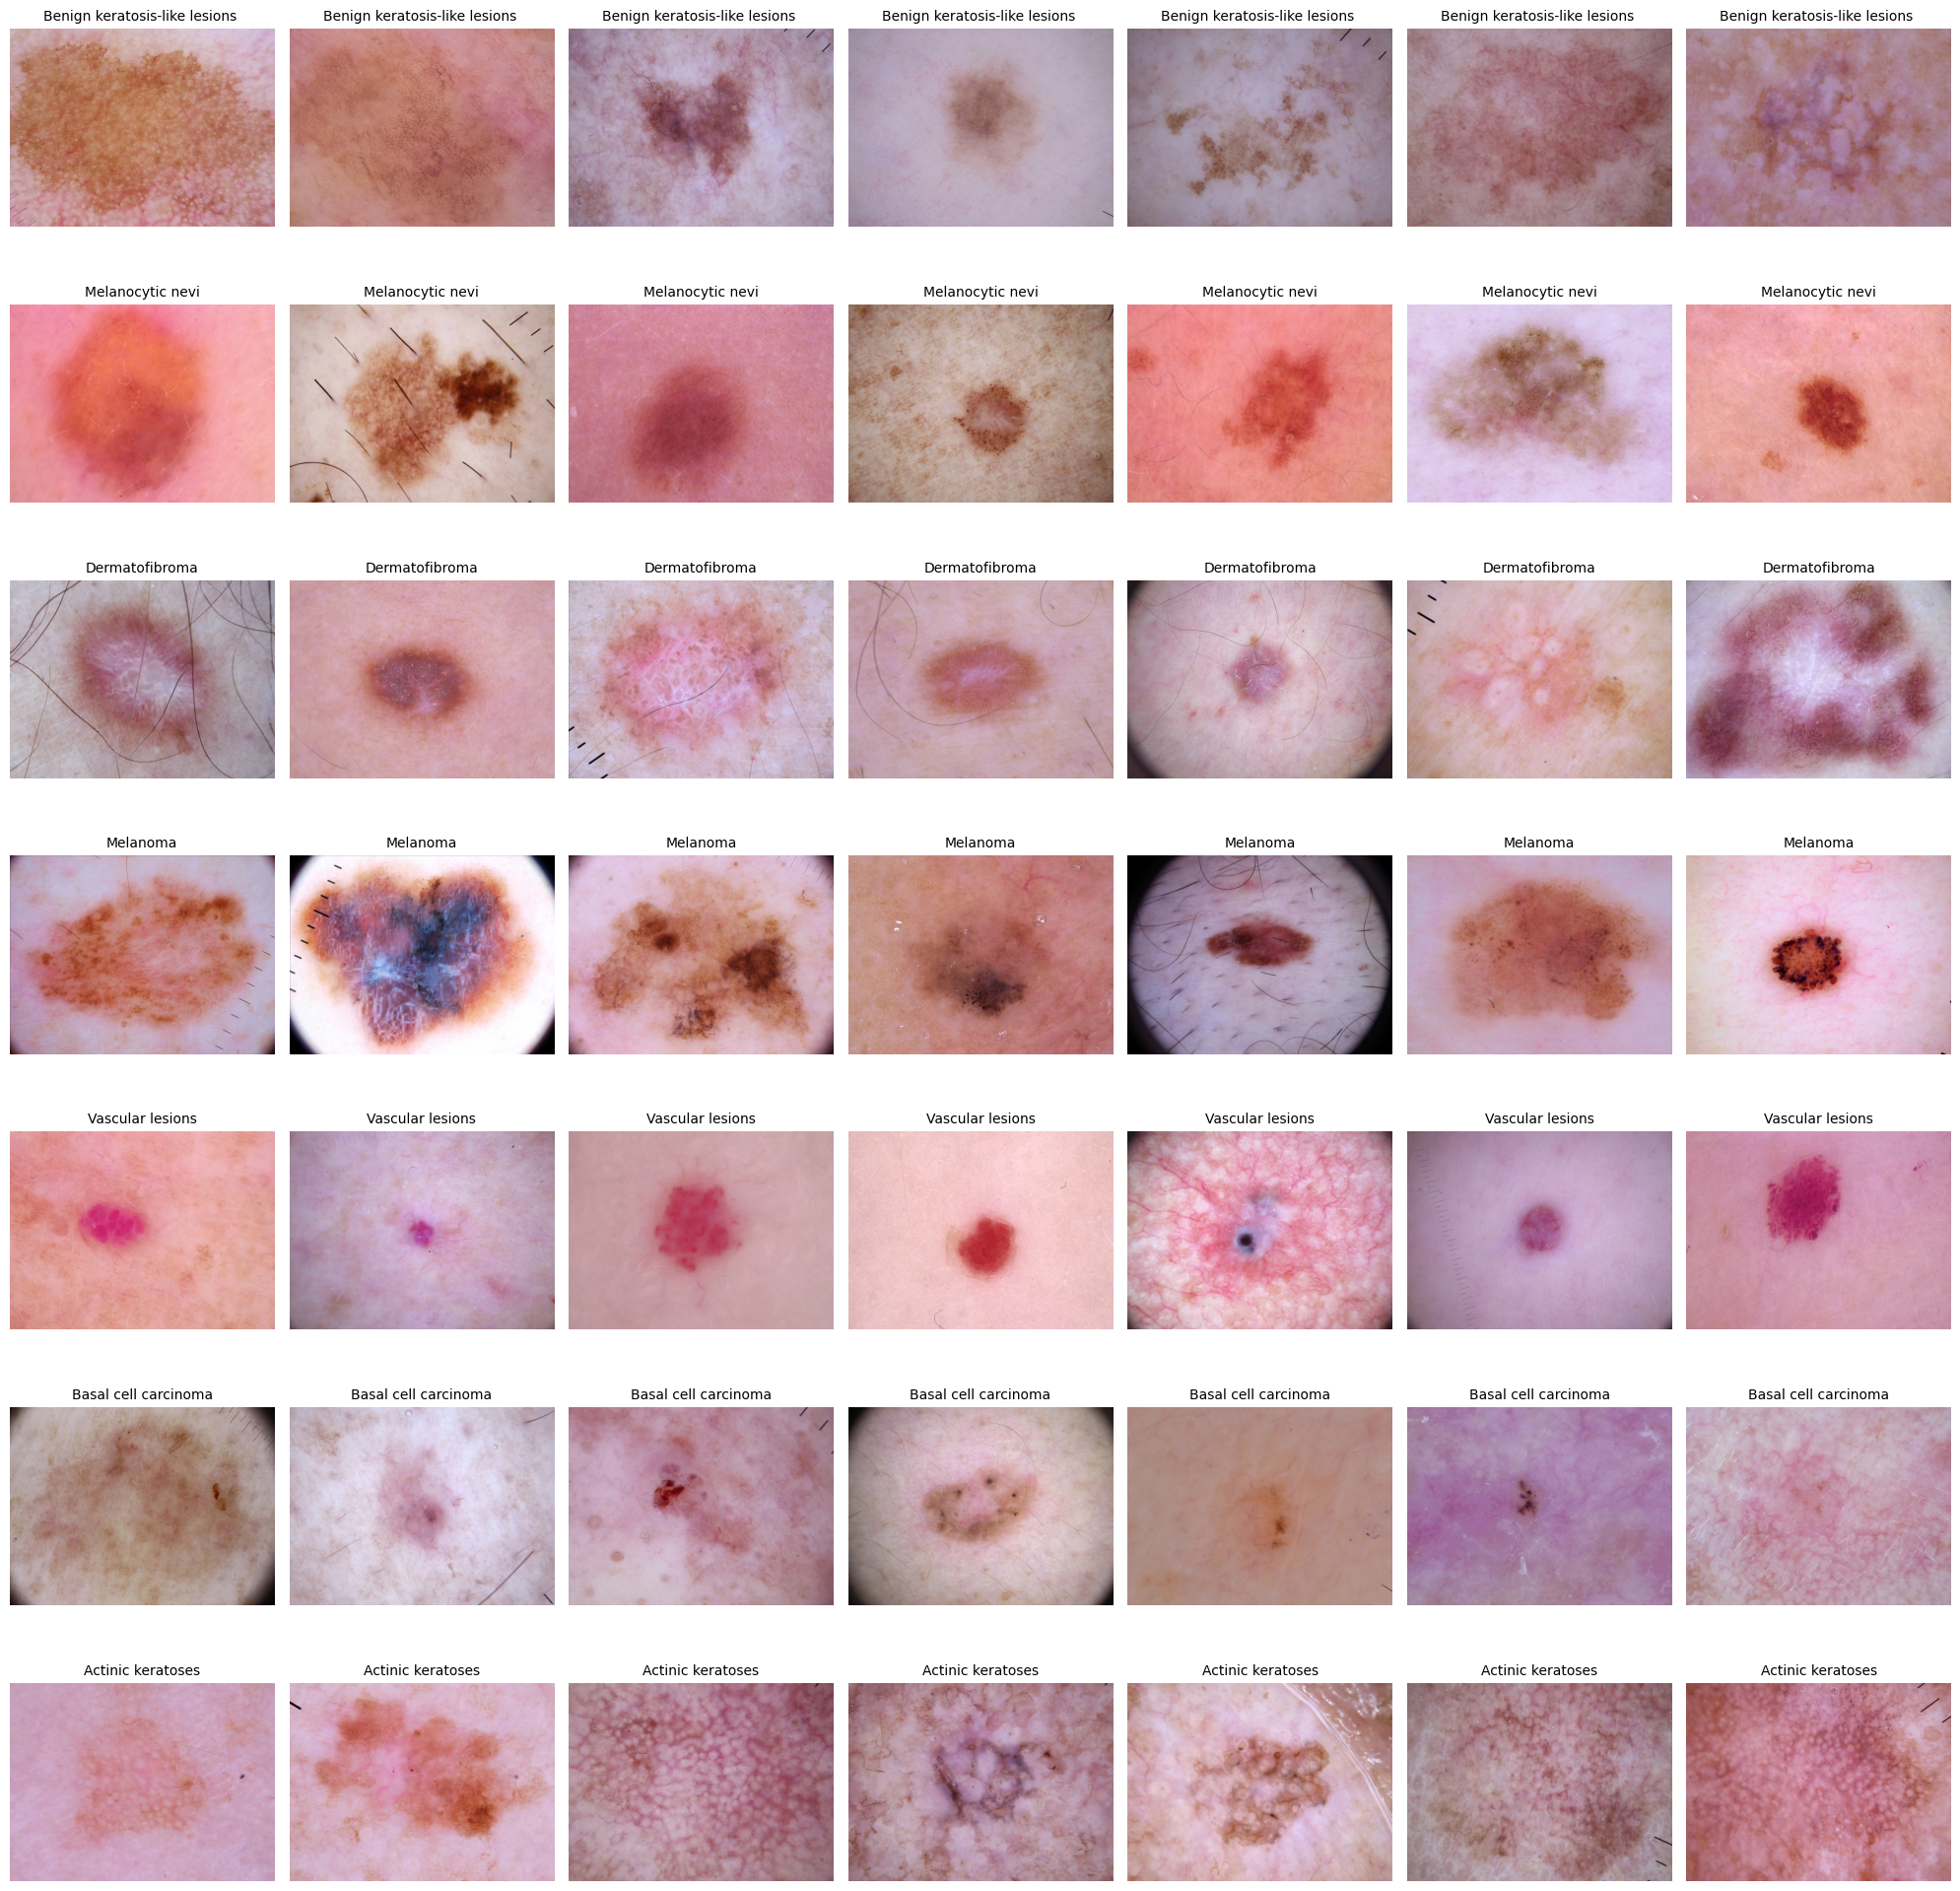

In [20]:
# Sample pics for each growth type

def load_image(image_path):
    return Image.open(image_path)

#Select Samples
unique_classes = skin_df['cell_type'].unique()
samples_per_class = 7

# Dictionary to hold selected samples
selected_samples = {class_: [] for class_ in unique_classes}

for class_ in unique_classes:
    # Filter samples by class and randomly select
    class_samples = skin_df[skin_df['cell_type'] == class_].sample(n=samples_per_class, random_state=42)
    for _, row in class_samples.iterrows():
        img = load_image(row['image_path'])  # Load the image
        selected_samples[class_].append(img)

# Visualize with class names
fig, axs = plt.subplots(len(unique_classes), samples_per_class, figsize=(20, 20))

for class_idx, class_ in enumerate(unique_classes):
    for img_idx, img in enumerate(selected_samples[class_]):
        ax = axs[class_idx, img_idx]
        ax.imshow(img)
        ax.axis('off')
        # Set title for the first image in each row to the class name
        if img_idx == 0:
            ax.set_ylabel(class_, rotation=0, size='large', labelpad=60, verticalalignment='center')
        # Optionally, add class names to each image
        ax.set_title(class_, fontsize=10)

plt.tight_layout()
plt.show()


# EDA

In [21]:
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   dataset        10015 non-null  object 
 8   image_path     10015 non-null  object 
 9   cell_type      10015 non-null  object 
 10  cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(9)
memory usage: 792.3+ KB


In [22]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
dataset           0
image_path        0
cell_type         0
cell_type_idx     0
dtype: int64

there are 57 null samples in age so they need to be filled. The mean of the total age will be used to fill the na

In [23]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
dataset          0
image_path       0
cell_type        0
cell_type_idx    0
dtype: int64

In [24]:
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            10015 non-null  float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   dataset        10015 non-null  object 
 8   image_path     10015 non-null  object 
 9   cell_type      10015 non-null  object 
 10  cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(9)
memory usage: 792.3+ KB


now we see that there are no null in the dataframe

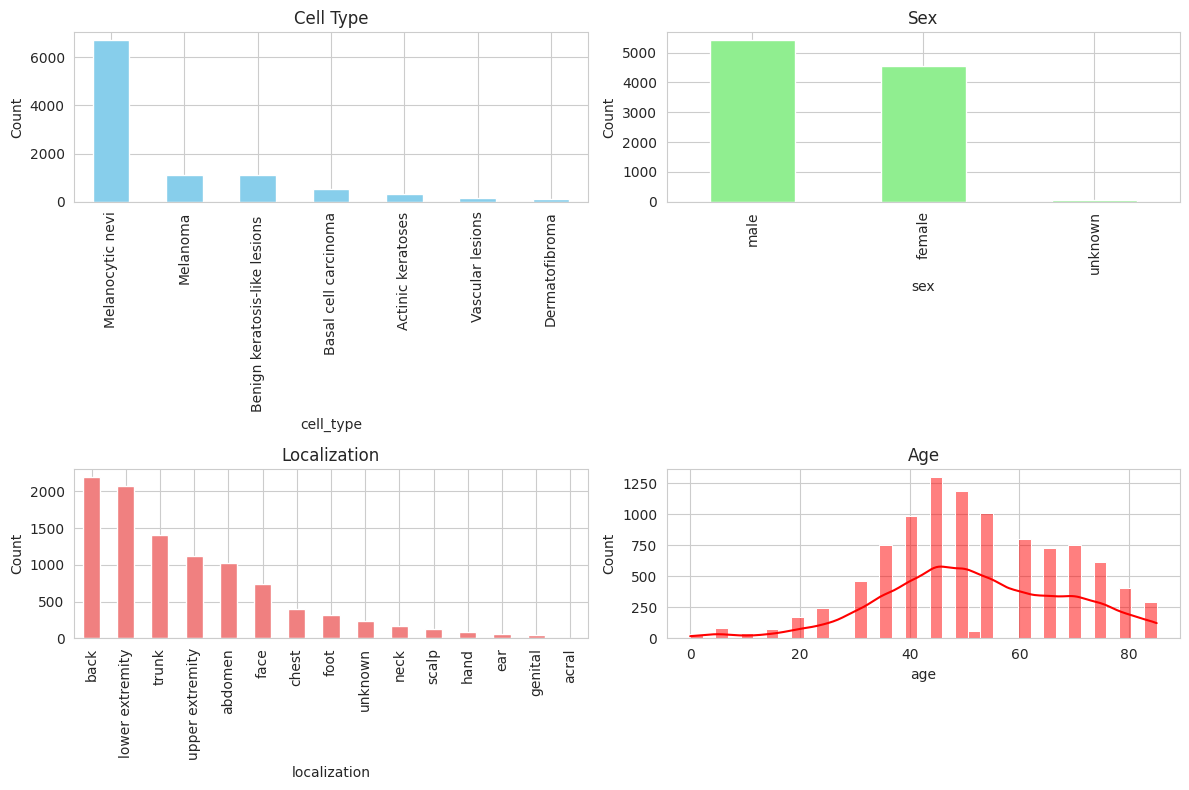

In [25]:
# using graphs we can check the distribution of the growth
sns.set_style("whitegrid")

# Initialize the figure with a size
plt.figure(figsize=(12, 8))

# Plot for Cell Type
plt.subplot(221)  # 2x2 grid, first subplot
skin_df['cell_type'].value_counts().plot(kind='bar', color='skyblue')
plt.ylabel('Count')
plt.title('Cell Type')

# Plot for Sex distribution
plt.subplot(222)  # 2x2 grid, second subplot
skin_df['sex'].value_counts().plot(kind='bar', color='lightgreen')
plt.ylabel('Count')
plt.title('Sex')

# Plot for Localization distribution
plt.subplot(223)  # 2x2 grid, third subplot
skin_df['localization'].value_counts().plot(kind='bar', color='lightcoral')
plt.ylabel('Count')
plt.title('Localization')

# Plot for Age distribution
plt.subplot(224)  # 2x2 grid, fourth subplot
# Filter out null ages, no need for a separate variable
sns.histplot(skin_df[skin_df['age'].notnull()]['age'], kde=True, color='red')
plt.title('Age')

# Automatically adjust subplot params for a neat layout
plt.tight_layout()

# Display the plots
plt.show()


In [26]:
print(skin_df['cell_type'].value_counts())

cell_type
Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: count, dtype: int64


In [27]:
print(skin_df['localization'].value_counts())

localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64


There appears to be a very different distribution of the number of lessions so there will be a need to deal with it

In [28]:
#creating vtrain and test split
y = skin_df['cell_type_idx']
X = skin_df.drop('cell_type_idx', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
X_train.head()

lesion_id      image_id   dx    dx_type   age     sex  \
6582  HAM_0004772  ISIC_0027223   nv  follow_up  35.0  female   
7194  HAM_0002136  ISIC_0032914   nv      histo  75.0    male   
9446  HAM_0007333  ISIC_0033614   nv  consensus  40.0    male   
533   HAM_0006399  ISIC_0026219  bkl      histo  60.0  female   
132   HAM_0002040  ISIC_0033900  bkl      histo  50.0  female   

         localization        dataset  \
6582             back  vidir_molemax   
7194  upper extremity   vidir_modern   
9446          unknown   vidir_modern   
533              back      rosendahl   
132   lower extremity   vidir_modern   

                                             image_path  \
6582  /content/drive/MyDrive/Data Scientist/final pr...   
7194  /content/drive/MyDrive/Data Scientist/final pr...   
9446  /content/drive/MyDrive/Data Scientist/final pr...   
533   /content/drive/MyDrive/Data Scientist/final pr...   
132   /content/drive/MyDrive/Data Scientist/final pr...   

                           cell_type  
6582                Melanocytic nevi  
7194                Melanocytic nevi  
9446                Melanocytic nevi  
533   Benign keratosis-like lesions   
132   Benign keratosis-like lesions

In [30]:
# Combine train image and label dataframe as one dataframe to have a complete dataframe to work on
X_train.insert(0, 'cell_type_idx', value=y_train.values)
train_df = X_train
X_test.insert(0, 'cell_type_idx', value=y_test.values)
test_df = X_test

In [31]:
test_df.head()

cell_type_idx    lesion_id      image_id   dx    dx_type   age     sex  \
1617              5  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128              4  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168              5  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090              2  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754              4  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   

         localization        dataset  \
1617             face   vidir_modern   
8128  lower extremity    vienna_dias   
2168             back      rosendahl   
1090            trunk  vidir_molemax   
7754          abdomen   vidir_modern   

                                             image_path  \
1617  /content/drive/MyDrive/Data Scientist/final pr...   
8128  /content/drive/MyDrive/Data Scientist/final pr...   
2168  /content/drive/MyDrive/Data Scientist/final pr...   
1090  /content/drive/MyDrive/Data Scientist/final pr...   
7754  /content/drive/MyDrive/Data Scientist/final pr...   

                           cell_type  
1617                        Melanoma  
8128                Melanocytic nevi  
2168                        Melanoma  
1090  Benign keratosis-like lesions   
7754                Melanocytic nevi

In [32]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2003 entries, 1617 to 4823
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cell_type_idx  2003 non-null   int8   
 1   lesion_id      2003 non-null   object 
 2   image_id       2003 non-null   object 
 3   dx             2003 non-null   object 
 4   dx_type        2003 non-null   object 
 5   age            2003 non-null   float64
 6   sex            2003 non-null   object 
 7   localization   2003 non-null   object 
 8   dataset        2003 non-null   object 
 9   image_path     2003 non-null   object 
 10  cell_type      2003 non-null   object 
dtypes: float64(1), int8(1), object(9)
memory usage: 174.1+ KB


# Normalizing the train dataset

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8012 entries, 6582 to 7270
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cell_type_idx  8012 non-null   int8   
 1   lesion_id      8012 non-null   object 
 2   image_id       8012 non-null   object 
 3   dx             8012 non-null   object 
 4   dx_type        8012 non-null   object 
 5   age            8012 non-null   float64
 6   sex            8012 non-null   object 
 7   localization   8012 non-null   object 
 8   dataset        8012 non-null   object 
 9   image_path     8012 non-null   object 
 10  cell_type      8012 non-null   object 
dtypes: float64(1), int8(1), object(9)
memory usage: 696.4+ KB


In [34]:
# max class
print("Class distribution after balancing:\n", train_df['cell_type_idx'].value_counts())

Class distribution after balancing:
 cell_type_idx
4    5367
5     887
2     871
1     421
0     258
6     121
3      87
Name: count, dtype: int64


In [35]:
#Creating copies to balance the  train data
max_class_size = 5367
df_list = []

for class_index, group in train_df.groupby('cell_type_idx'):
    df_class_balanced = resample(group,
                                 replace=True,     # Sample with replacement
                                 n_samples=max_class_size,    # Match number in majority class
                                 random_state=123) # Reproducible results
    df_list.append(df_class_balanced)

# Combine all oversampled classes back into one DataFrame
train_df_balanced = pd.concat(df_list)


In [36]:
train_df_balanced = train_df_balanced.sample(frac=1, random_state=123).reset_index(drop=True)

In [37]:
test_df = test_df.sample(frac=1, random_state=123).reset_index(drop=True)

In [38]:
# Verify the balancing
print("Class distribution after balancing:\n", train_df_balanced['cell_type_idx'].value_counts())

Class distribution after balancing:
 cell_type_idx
0    5367
4    5367
1    5367
5    5367
6    5367
3    5367
2    5367
Name: count, dtype: int64


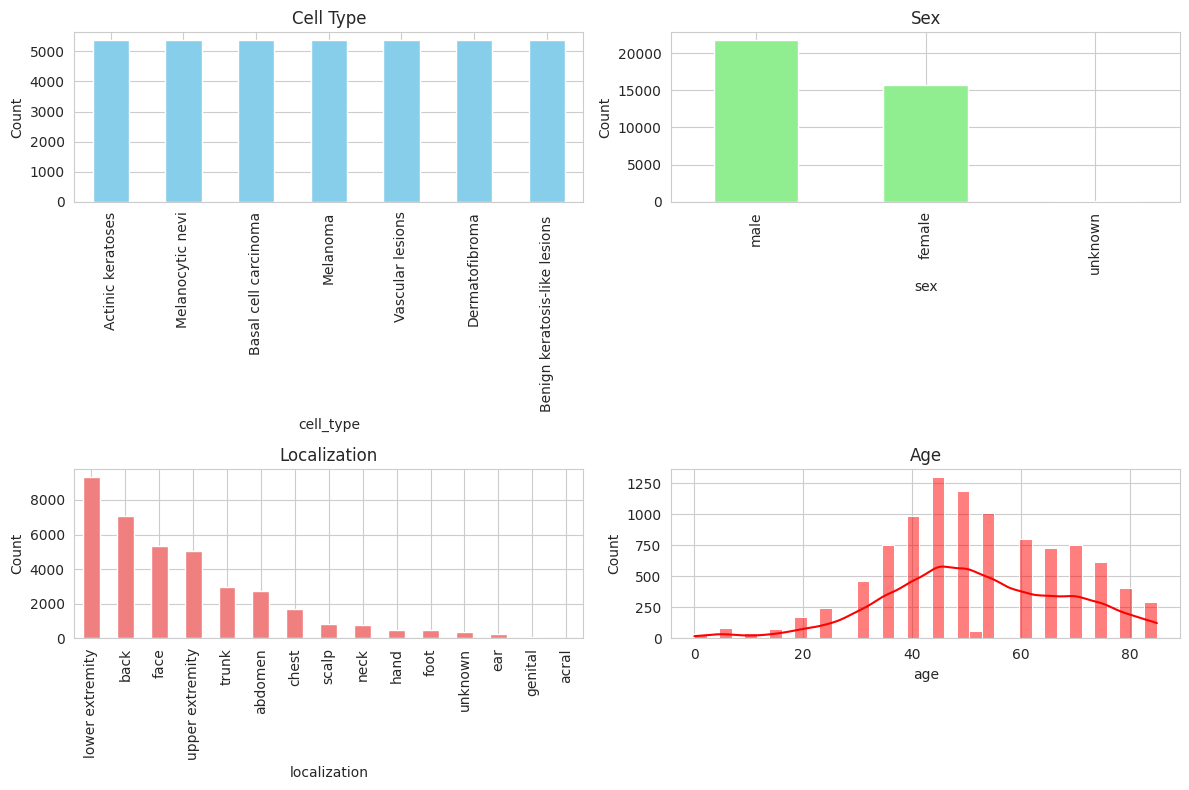

In [39]:
# Set the style of seaborn for more appealing plots
sns.set_style("whitegrid")

# Initialize the figure with a size
plt.figure(figsize=(12, 8))

# Plot for Cell Type
plt.subplot(221)  # 2x2 grid, first subplot
train_df_balanced['cell_type'].value_counts().plot(kind='bar', color='skyblue')
plt.ylabel('Count')
plt.title('Cell Type')

# Plot for Sex distribution
plt.subplot(222)  # 2x2 grid, second subplot
train_df_balanced['sex'].value_counts().plot(kind='bar', color='lightgreen')
plt.ylabel('Count')
plt.title('Sex')

# Plot for Localization distribution
plt.subplot(223)  # 2x2 grid, third subplot
train_df_balanced['localization'].value_counts().plot(kind='bar', color='lightcoral')
plt.ylabel('Count')
plt.title('Localization')

# Plot for Age distribution
plt.subplot(224)  # 2x2 grid, fourth subplot
# Filter out null ages, no need for a separate variable
sns.histplot(skin_df[skin_df['age'].notnull()]['age'], kde=True, color='red')
plt.title('Age')

# Automatically adjust subplot params for a neat layout
plt.tight_layout()

# Display the plots
plt.show()

In [40]:

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Initialize the dataset.

        Parameters:
            dataframe (pd.DataFrame): DataFrame containing image paths and labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        """
        Return the number of items in the dataset.
        """
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Fetch the item (image and label) at the specified index.

        Parameters:
            idx (int): Index of the item to be fetched.

        Returns:
            tuple: (image, label) where image is the transformed image and label is the class label.
        """
        # Use the full path directly from the DataFrame
        img_path = self.dataframe.iloc[idx]['image_path']  # Adjust column name as necessary
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(int(self.dataframe['cell_type_idx'][idx]))

        if self.transform:
            image = self.transform(image)

        return image, label


# Model Preparation

In [41]:
# Hyperparameters & settings
num_classes = 7  # Adjust to your dataset
batch_size = 32
num_epochs = 20  # You can adjust the number of epochs
learning_rate = 0.001


In [42]:
#data augmentation
train_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomRotation(20),
                                     transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [43]:
# Create the dataset
train_data_torch = CustomImageDataset(train_df_balanced, transform=train_transform)
test_data_torch = CustomImageDataset(test_df, transform=test_transform)

In [44]:
# Create dataloaders
train_loader = DataLoader(train_data_torch, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data_torch, batch_size=batch_size)


In [45]:
wandb.init(project='Final Project HAM10000 - balanced - vgg16')
wandb.config = {
  "learning_rate": learning_rate,
  "epochs": num_epochs,
  "batch_size": train_loader.batch_size
}


wandb: Currently logged in as: daniel-baumel (daniel-name). Use `wandb login --relogin` to force relogin


In [46]:
# Load the pre-trained vgg16 model
model = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 117MB/s]


In [47]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
# Modify the last layer
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

In [49]:
# Then move the model to the GPU
model = model.to(device)

In [50]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Model training

In [51]:

model.train()  # Set the model to training mode
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to the appropriate device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Log the metrics to wandb
    wandb.log({"epoch": epoch+1, "loss": epoch_loss})

Epoch 1/20, Loss: 0.8050
Epoch 2/20, Loss: 0.4177
Epoch 3/20, Loss: 0.2945
Epoch 4/20, Loss: 0.2297
Epoch 5/20, Loss: 0.1820
Epoch 6/20, Loss: 0.1522
Epoch 7/20, Loss: 0.1269
Epoch 8/20, Loss: 0.1131
Epoch 9/20, Loss: 0.0898
Epoch 10/20, Loss: 0.0840
Epoch 11/20, Loss: 0.0687
Epoch 12/20, Loss: 0.0626
Epoch 13/20, Loss: 0.0711
Epoch 14/20, Loss: 0.1044
Epoch 15/20, Loss: 0.0528
Epoch 16/20, Loss: 0.0441
Epoch 17/20, Loss: 0.0374
Epoch 18/20, Loss: 0.0385
Epoch 19/20, Loss: 0.0379
Epoch 20/20, Loss: 0.0292


# Evaluate the Model

In [52]:
model.eval()  # Set the model to evaluation mode

total_loss = 0.0
correct_predictions = 0
total_predictions = 0

# Criterion for calculating loss
criterion = torch.nn.CrossEntropyLoss()

# No gradient calculations
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate average loss and accuracy
avg_loss = total_loss / total_predictions
accuracy = correct_predictions / total_predictions * 100

# Log validation loss and accuracy to wandb
wandb.log({"val_loss": avg_loss, "val_accuracy": accuracy})

# Presenting the results
print(f'Validation Loss: {avg_loss:.4f}')
print(f'Validation Accuracy: {accuracy:.2f}%')


Validation Loss: 0.7244
Validation Accuracy: 83.97%


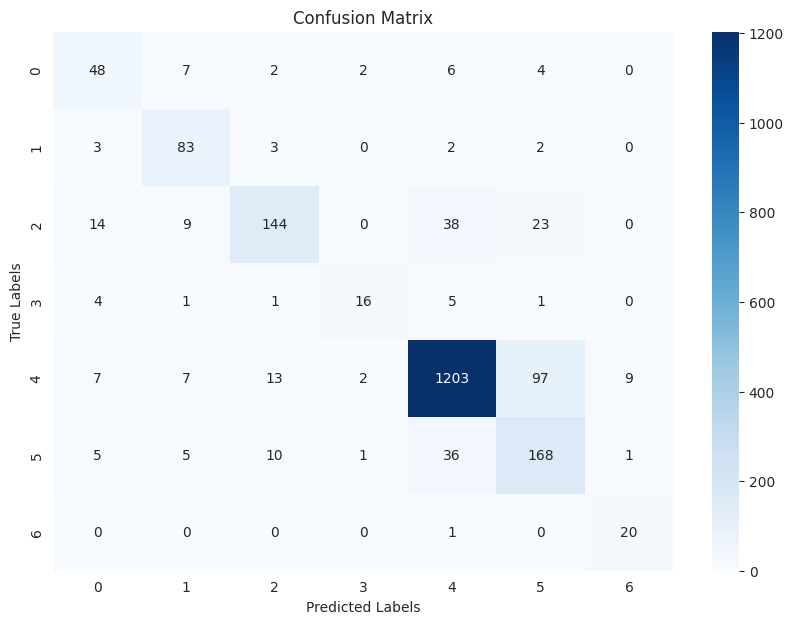

In [57]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store true and predicted labels
true_labels = []
pred_labels = []

# Disable gradient calculation for inference
with torch.no_grad():
    for images, labels in test_loader:

        # Move images to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get the prediction class with the highest score
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels for this batch
        # Move tensors to CPU before converting to NumPy
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [58]:
wandb.finish()

In [61]:
# Define the directory path where you want to save the file
dir_path = '/content/drive/My Drive'


# Define the full path to the file
filename = 'balanced_vgg16_pickle.pkl'
file_path = os.path.join(dir_path, filename)

with open(file_path, 'wb') as file:
    pickle.dump(model, file)

print(f'Model saved to {file_path}')

Model saved to /content/drive/My Drive/balanced_vgg16_pickle.pkl


In [60]:
from google.colab import drive
drive.mount('/content/drive')

filename = 'balanced_vgg16_model.pth'
model_path = '/content/drive/My Drive/' + filename  # Save to Google Drive

torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/My Drive/balanced_vgg16_model.pth


In [54]:
# saving Model with pickle

import pickle

# Saving the model to a file
filename = 'balanced_vgg16_pickle.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print(f'Model saved to {filename}')


Model saved to balanced_vgg16_pickle.pkl


In [55]:
# Saving a PyTorch Model - Saving the entire model
filename = 'balancad_vgg16_pytorch.pth'
torch.save(model, filename)

print(f'Entire model saved to {filename}')

Entire model saved to balancad_vgg16_pytorch.pth
